<a href="https://colab.research.google.com/github/mmcastillo/al112248/blob/main/3D_Attention_ResUNet_modificada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modificaciones:
Se disminuye a 3 el número de submuestreos (downsampling)

In [163]:
pip install patchify

In [164]:
!pip install segmentation-models-3D --quiet

In [165]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.13.0
2.13.1


In [166]:
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from google.colab import drive
drive.mount('/content/drive/');
import os
from keras.models import Model
from keras import layers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate, Flatten, Dense
import random

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [167]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)
            if image.shape[3]==3:

                  image = image[:,:,:,0]
                  image = np.expand_dims(image,-1)

            images.append(image)
    images = np.array(images)

    return(images)

In [168]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            X = np.float32(X)
            Y = np.float32(Y)

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [169]:
train_img_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/aug_aneurismas_completos/imgs/';
train_mask_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/aug_aneurismas_completos/masks/';
train_img_list_comp = os.listdir(train_img_dir)
train_mask_list_comp = os.listdir(train_mask_dir)

val_img_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/val_aneurismas_completos/imgs/';
val_mask_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/val_aneurismas_completos/masks/';
val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)


#Se toma una muestra de la lista de patches de entrenamiento para hacer pruebas
train_img_list = []
train_mask_list = []
indices_aleatorios = random.sample(range(0,len(train_img_list_comp)),400)
for i in indices_aleatorios:
  train_img_list.append(train_img_list_comp[i])
  train_mask_list.append(train_mask_list_comp[i])

'''
list_train_pos = []
list_train_pos_mask = []
for i in range(0,len(train_img_list)):
  mask_patches = np.load(train_mask_dir + train_mask_list[i])
  if np.unique(mask_patches).shape[0]==2:
      list_train_pos.append(train_img_list[i])
      list_train_pos_mask.append(train_mask_list[i])
'''

print('para entrenar se toman', len(train_img_list),'imágenes y para validación', len(val_img_list))
print('para entrenar se toman', len(train_mask_list),'máscaras y para validación', len(val_mask_list))

para entrenar se toman 400 imágenes y para validación 7
para entrenar se toman 400 máscaras y para validación 7


In [170]:
print(train_img_list)
print(train_mask_list)

['34_7.npy', '5_5.npy', '42_45.npy', '22_41.npy', '16_35.npy', '1_44.npy', '4_28.npy', '24_53.npy', '43_24.npy', '21_4.npy', '12_40.npy', '29_52.npy', '25_37.npy', '47_28.npy', '8_62.npy', '8_61.npy', '24_29.npy', '21_35.npy', '26_51.npy', '42_47.npy', '42_32.npy', '24_5.npy', '15_16.npy', '10_30.npy', '38_48.npy', '29_28.npy', '20_60.npy', '31_4.npy', '15_2.npy', '33_41.npy', '7_33.npy', '16_39.npy', '4_13.npy', '20_15.npy', '27_9.npy', '19_58.npy', '46_5.npy', '42_24.npy', '28_56.npy', '23_2.npy', '36_20.npy', '12_4.npy', '22_40.npy', '21_56.npy', '41_61.npy', '33_7.npy', '29_49.npy', '9_17.npy', '23_20.npy', '43_20.npy', '18_34.npy', '6_23.npy', '31_22.npy', '24_43.npy', '24_37.npy', '17_10.npy', '10_orig.npy', '16_22.npy', '21_62.npy', '10_5.npy', '10_49.npy', '20_4.npy', '25_57.npy', '34_9.npy', '42_13.npy', '33_60.npy', '39_54.npy', '24_50.npy', '31_47.npy', '48_8.npy', '23_60.npy', '27_52.npy', '33_56.npy', '45_42.npy', '6_46.npy', '32_48.npy', '36_61.npy', '12_36.npy', '22_61.n

In [171]:
batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, 7)

(7, 64, 64, 64, 1)
(7, 64, 64, 64, 1)
[0. 1.]


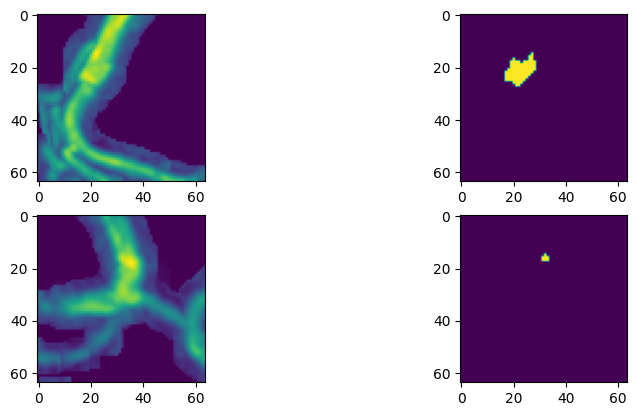

In [172]:
img,mask = val_img_datagen.__next__()
print(img.shape)
print(mask.shape)
print(np.unique(mask))
plt.figure(figsize =(10,10))
plt.subplot(4,2,1)
plt.imshow(np.max(img[0,:,:,:,0],2));
plt.subplot(4,2,2)
plt.imshow(np.max(mask[0,:,:,:,0],2));
plt.subplot(4,2,3)
plt.imshow(np.max(img[1,:,:,:,0],2));
plt.subplot(4,2,4)
plt.imshow(np.max(mask[1,:,:,:,0],2));

In [173]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-5):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice

def gen_dice_loss(y_true, y_pred):  #Generalized Dice Loss
    num, den = 0, 0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    wg = 1/((K.sum(y_true_f)+ 1e-10)**2)
    I1 = K.sum(y_true_f * y_pred_f)
    I2 = K.sum(y_pred_f + y_true_f)
    num += wg*I1
    den += wg*I2
    GDLoss = 1 - 2*((num + 1e-10)/(den + 1e-10))
    return GDLoss

def dice_loss(y_true, y_pred):  #Generalized Dice Loss
    num, den = 0, 0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    wg=1
    I1 = K.sum(y_true_f * y_pred_f)
    I2 = K.sum(y_pred_f + y_true_f)
    num += wg*I1
    den += wg*I2
    DLoss = 1 - 2*((num + 1e-10)/(den + 1e-10))
    return DLoss


def diceCEloss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
      y_pred = tf.math.sigmoid(y_pred)
      numerator = 2 * tf.reduce_sum(y_true * y_pred)
      denominator = tf.reduce_sum(y_true + y_pred)

      return 1 - numerator / denominator

    y_true = tf.cast(y_true, tf.float32)
    o = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred) + dice_loss(y_true, y_pred)
    return tf.reduce_mean(o)

## Modelo 3D Attention ResUNet

In [174]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=-1)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=-1)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=-1)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=-1)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv3D(size, kernel_size=(1, 1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=-1)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv3D(out_size, (1, 1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv3D(inter_shape, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv3D(inter_shape, (1, 1, 1), padding='same')(gating)
    upsample_g = layers.Conv3DTranspose(inter_shape, (3, 3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2], shape_theta_x[3] // shape_g[3]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv3D(1, (1, 1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling3D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2], shape_x[3] // shape_sigmoid[3]))(sigmoid_xg)  # 32

    #upsample_psi = repeat_elem(upsample_psi, shape_x[4])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv3D(shape_x[4], (1, 1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Residual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter (tamaño del kernel = 3,3,3)
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 4

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_64 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)       #64
    pool_32 = layers.MaxPooling3D(pool_size=(2,2,2))(conv_64)                                 #(32,32,32)
    # DownRes 2
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)     #128
    pool_16 = layers.MaxPooling3D(pool_size=(2,2,2))(conv_32)                                  #(16,16,16)
    # DownRes 3
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)     #256
    pool_8 = layers.MaxPooling3D(pool_size=(2,2,2))(conv_16)                                  #(8,8,8)

    # DownRes 4, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)     #512 (8,8,8)

    # UpRes 5, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 4*FILTER_NUM, batch_norm)                                                          #256
    att_16 = attention_block(conv_16, gating_16, 4*FILTER_NUM)
    up_16 = layers.UpSampling3D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)    #(16,16,16)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 6
    gating_32 = gating_signal(up_conv_16, 2*FILTER_NUM, batch_norm)                                                          #128
    att_32 = attention_block(conv_32, gating_32, 2*FILTER_NUM)
    up_32 = layers.UpSampling3D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)    #(32,32,32)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_64 = gating_signal(up_conv_32, FILTER_NUM, batch_norm)                                                           #64
    att_64 = attention_block(conv_64, gating_64, FILTER_NUM)
    up_64 = layers.UpSampling3D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)   #(64,64,64)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv3D(NUM_CLASSES, kernel_size=(1,1,1))(up_conv_64)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = Model(inputs, conv_final, name="AttentionResUNetMod")
    return model

In [175]:
IMG_HEIGHT = img.shape[1]
IMG_WIDTH  = img.shape[2]
IMG_DEPTH = img.shape[3]
IMG_CHANNELS = img.shape[4]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH,IMG_CHANNELS)

att_res_unet_model = Attention_ResUNet(input_shape)

In [176]:
#%%
for i, layer in enumerate(att_res_unet_model.layers):
    print('Nombre: ', layer.name, ', numero: ', i)
# La salida del encoder es conv_8 y es la capa numero
#%%

Nombre:  input_2 , numero:  0
Nombre:  conv3d_37 , numero:  1
Nombre:  batch_normalization_28 , numero:  2
Nombre:  activation_24 , numero:  3
Nombre:  conv3d_39 , numero:  4
Nombre:  conv3d_38 , numero:  5
Nombre:  batch_normalization_30 , numero:  6
Nombre:  batch_normalization_29 , numero:  7
Nombre:  add_10 , numero:  8
Nombre:  activation_25 , numero:  9
Nombre:  max_pooling3d_3 , numero:  10
Nombre:  conv3d_40 , numero:  11
Nombre:  batch_normalization_31 , numero:  12
Nombre:  activation_26 , numero:  13
Nombre:  conv3d_42 , numero:  14
Nombre:  conv3d_41 , numero:  15
Nombre:  batch_normalization_33 , numero:  16
Nombre:  batch_normalization_32 , numero:  17
Nombre:  add_11 , numero:  18
Nombre:  activation_27 , numero:  19
Nombre:  max_pooling3d_4 , numero:  20
Nombre:  conv3d_43 , numero:  21
Nombre:  batch_normalization_34 , numero:  22
Nombre:  activation_28 , numero:  23
Nombre:  conv3d_45 , numero:  24
Nombre:  conv3d_44 , numero:  25
Nombre:  batch_normalization_36 , num

In [177]:
att_res_unet_model.compile(tf.keras.optimizers.Adam(learning_rate = 0.00005),
                           loss = gen_dice_loss,
                            metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5), dice_coef])

print(att_res_unet_model.summary())

Model: "AttentionResUNetMod"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 64, 1)]      0         []                            
                                                                                                  
 conv3d_37 (Conv3D)          (None, 64, 64, 64, 64)       1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_28 (Ba  (None, 64, 64, 64, 64)       256       ['conv3d_37[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_24 (Activation)  (None, 64, 64, 64, 64)       0         ['batch_norm

In [178]:
from tensorflow import math
num_modelo = 11

filepath = '/content/drive/MyDrive/DOCTORADO/3DAttResUNetModificada_' + str(num_modelo) + '.h5'

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=10, min_lr=0.00001)

stop_callback = keras.callbacks.EarlyStopping(monitor='dice_coef',mode = 'max' , patience=30)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_dice_coef',
    verbose = 1,
    mode='max',
    save_best_only=True,
    initial_value_threshold=0.29
    )

ruta_hist = '/content/drive/MyDrive/DOCTORADO/'
csv_logger_callback = keras.callbacks.CSVLogger(ruta_hist + 'history_3DAttResUNet_'+ str(num_modelo) + '.csv', separator=',', append=True)

In [180]:
num_modelo = 11

filepath = '/content/drive/MyDrive/DOCTORADO/3DAttResUNetModificada_' + str(num_modelo) + '.h5'

from keras.models import load_model
att_res_unet_model.load_weights(filepath)

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

history=att_res_unet_model.fit(train_img_datagen,
          steps_per_epoch = steps_per_epoch,
          epochs = 30,
          verbose = 1,
          validation_data = val_img_datagen,
          validation_steps = val_steps_per_epoch,
          callbacks = [reduce_lr, stop_callback, model_checkpoint_callback, csv_logger_callback]
          )

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.6745 - binary_io_u_5: 0.2096 - dice_coef: 0.3255
Epoch 1: val_dice_coef improved from 0.29000 to 0.48343, saving model to /content/drive/MyDrive/DOCTORADO/3DAttResUNetModificada_11.h5
100/100 [==============================] - 170s 2s/step - loss: 0.6745 - binary_io_u_5: 0.2096 - dice_coef: 0.3255 - val_loss: 0.5166 - val_binary_io_u_5: 0.3187 - val_dice_coef: 0.4834 - lr: 5.0000e-05
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.6679 - binary_io_u_5: 0.2137 - dice_coef: 0.3321
Epoch 2: val_dice_coef improved from 0.48343 to 0.48702, saving model to /content/drive/MyDrive/DOCTORADO/3DAttResUNetModificada_11.h5
100/100 [==============================] - 71s 715ms/step - loss: 0.6679 - binary_io_u_5: 0.2137 - dice_coef: 0.3321 - val_loss: 0.5130 - val_binary_io_u_5: 0.3223 - val_dice_coef: 0.4870 - lr: 5.0000e-05
Epoch 3/30
 89/100 [=========================>....] - ETA: 7s - loss: 0.6597 - b

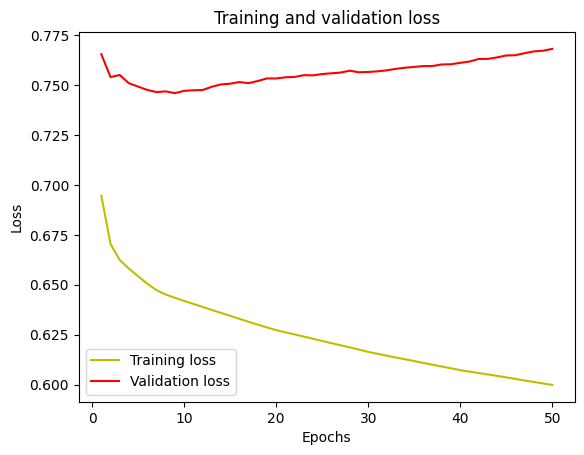

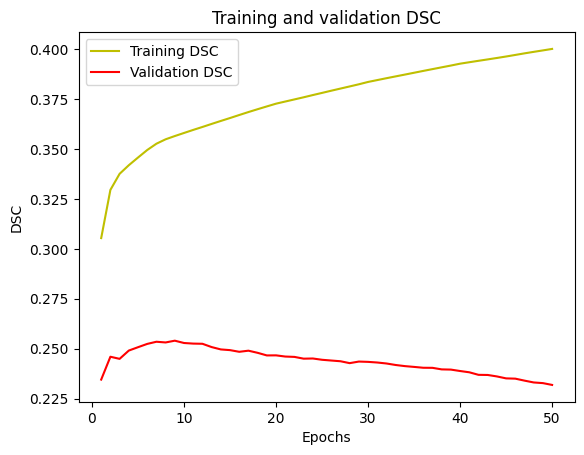

In [154]:
#plot the training and validation IoU and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

plt.plot(epochs, train_dice_coef, 'y', label='Training DSC')
plt.plot(epochs, val_dice_coef, 'r', label='Validation DSC')
plt.title('Training and validation DSC')
plt.xlabel('Epochs')
plt.ylabel('DSC')
plt.legend()
plt.show()

## Visualizar resultados con el conjunto de validación

In [55]:
num_modelo = 10

filepath = '/content/drive/MyDrive/DOCTORADO/3DAttResUNetModificada_' + str(num_modelo) + '.h5'

from keras.models import load_model
att_res_unet_model.load_weights(filepath)

In [114]:
val_img_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/aug_aneurismas_completos_val/imgs/';
val_mask_dir = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_64x1/aug_aneurismas_completos_val/masks/';
val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [115]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

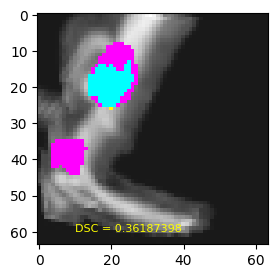

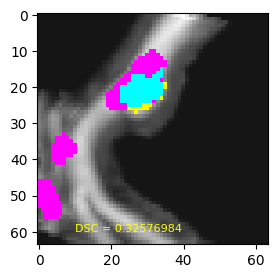

In [125]:
img,mask = val_img_datagen.__next__()
prediction = att_res_unet_model.predict(img,verbose=0)
prediction = prediction > 0.5

prediction = att_res_unet_model.predict(img,verbose=0)
prediction = prediction > 0.5

for caso in range(batch_size):
  img_caso = img[caso,:,:,:,0]
  mask_caso = mask[caso,:,:,:,0]
  ypred = prediction[caso,:,:,:,0]

  ytrue = tf.convert_to_tensor(mask[caso,:,:,:,:],dtype='float32')
  ypred = tf.convert_to_tensor(prediction[caso,:,:,:,:],dtype='float32')
  dice = dice_coef(ytrue, ypred).numpy()

  imagen_rgb = np.stack((img_caso,)*3, axis=-1)
  imagen_rgb = np.max(imagen_rgb,2)
  ypredmip = np.max(ypred,2)
  masktestmip = np.max(mask_caso,2)

  for i in range(ypredmip.shape[0]):
            for j in range(ypredmip.shape[1]):
                if ypredmip[i,j] != 0:
                  if ypredmip[i,j] == masktestmip[i,j]:
                    imagen_rgb[i,j,0] = 0
                    imagen_rgb[i,j,1] = 1
                    imagen_rgb[i,j,2] = 1
                  else:
                    imagen_rgb[i,j,0] = 1
                    imagen_rgb[i,j,1] = 0
                    imagen_rgb[i,j,2] = 1
                else:
                  if masktestmip[i,j] == 1:
                    imagen_rgb[i,j,0] = 1
                    imagen_rgb[i,j,1] = 1
                    imagen_rgb[i,j,2] = 0
  plt.figure(figsize=(3,3))
  plt.imshow(imagen_rgb)


  text = 'DSC = ' + str(dice)
  pos_x = 10
  pos_y = 60
  plt.text(pos_x, pos_y, text, color='yellow', fontsize=8)

  #legend_labels = ['TP', 'FP', 'FN']
  #legend_colors = [[0,1,1] , [1,0,1] , [1,1,0]]
  #legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in legend_colors]
  #plt.legend(legend_patches, legend_labels, loc='upper left')

In [128]:
#Carga conjunto de prueba
ruta_TOF = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_Preproc_Test/imgs/'
lista_archivos_TOF = os.listdir(ruta_TOF)
imgs_test =[]

for i in range(9):#(len(lista_archivos_TOF)):
  temp = np.load(ruta_TOF + lista_archivos_TOF[i])
  imgs_test.append(temp)

#Carga etiquetas de entrenamiento
ruta_mascaras = '/content/drive/MyDrive/DOCTORADO/Imágenes médicas/ADAM_Preproc_Test/mask/'
lista_archivos_mascaras = os.listdir(ruta_mascaras)
masks_test =[]

for i in range(9):#len(lista_archivos_mascaras)):
  temp = np.load(ruta_mascaras + lista_archivos_mascaras[i])
  masks_test.append(temp)

imgs_test = np.array(imgs_test)
masks_test = np.array(masks_test)

In [129]:
imgs_test.shape

(9, 512, 512, 128)

In [131]:
print(imgs_test.shape)
masks_test = masks_test[:,:,:,:,0]
print(masks_test.shape)

(9, 512, 512, 128)
(9, 512, 512, 128)


64/64 [==============================] - 7s 109ms/step
0.17311694
64/64 [==============================] - 7s 109ms/step
9.048136e-10
64/64 [==============================] - 7s 109ms/step
1.3104442e-09
64/64 [==============================] - 7s 109ms/step
1.5600624e-09
64/64 [==============================] - 7s 109ms/step
0.08983957
64/64 [==============================] - 7s 109ms/step
9.971084e-10
64/64 [==============================] - 7s 109ms/step
0.049971253
64/64 [==============================] - 7s 109ms/step
0.10726888
64/64 [==============================] - 7s 109ms/step
0.2543641


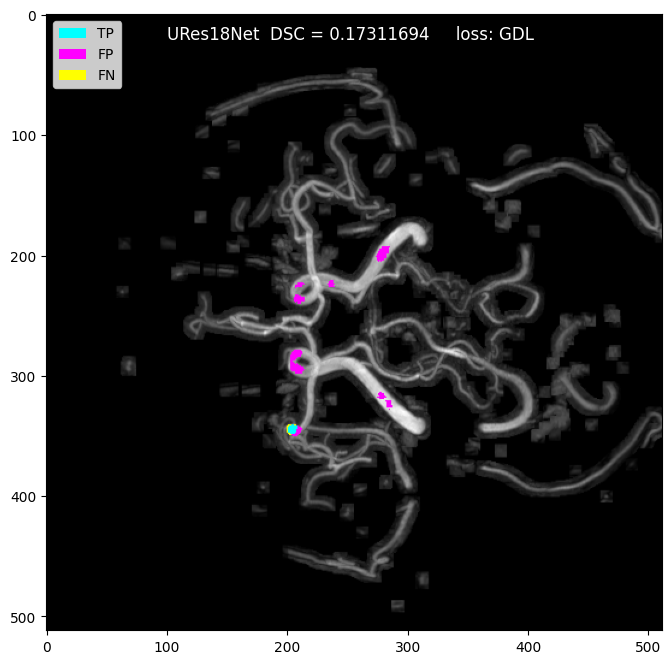

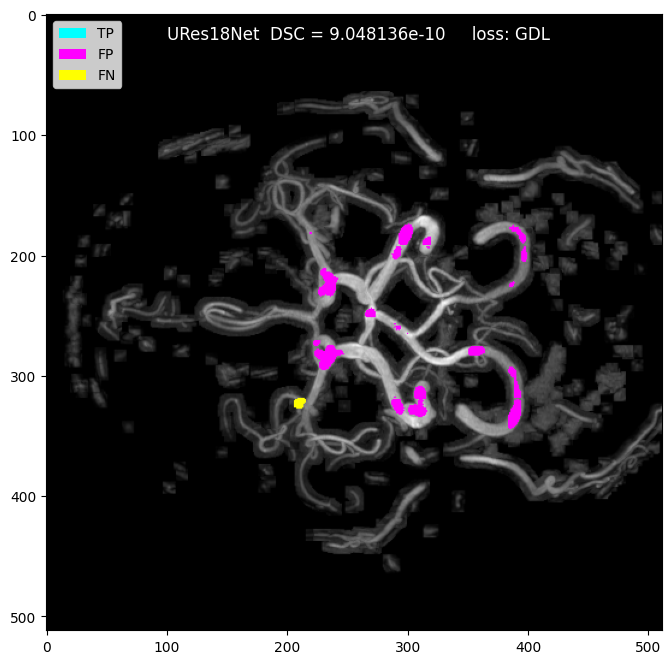

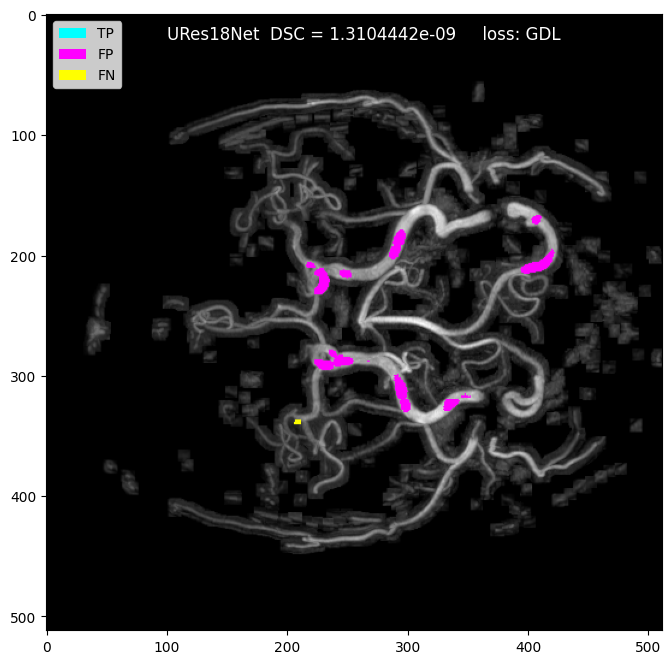

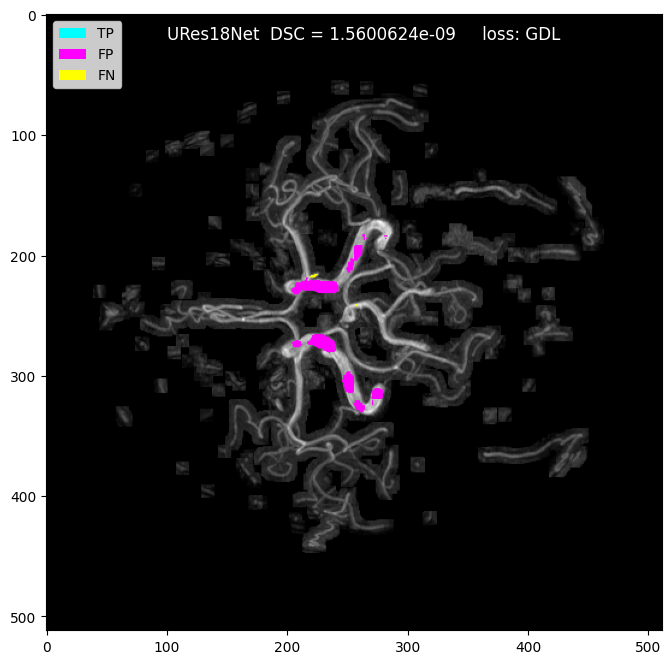

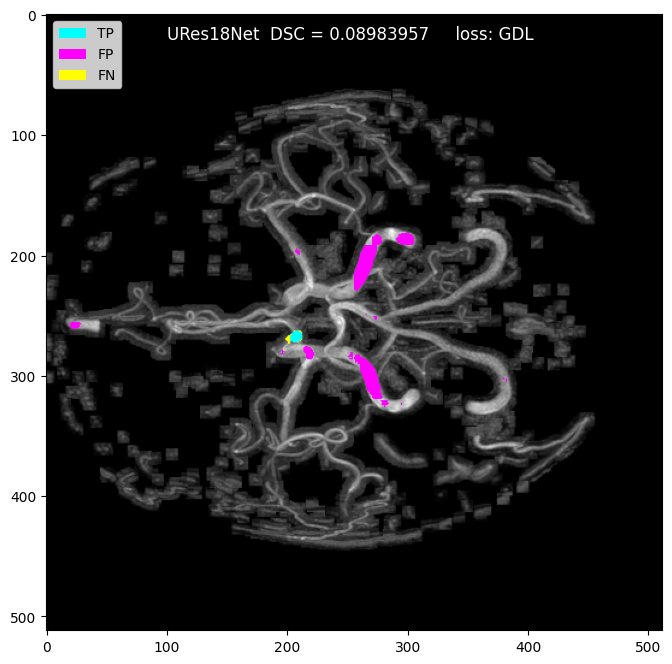

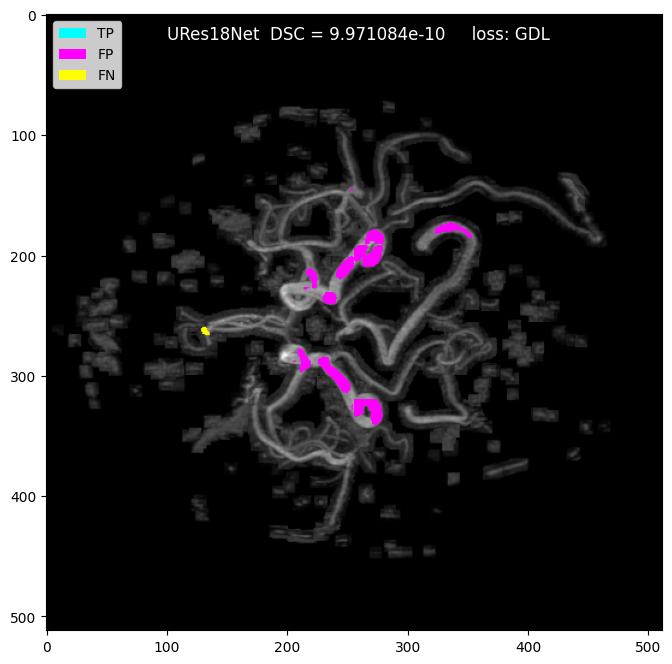

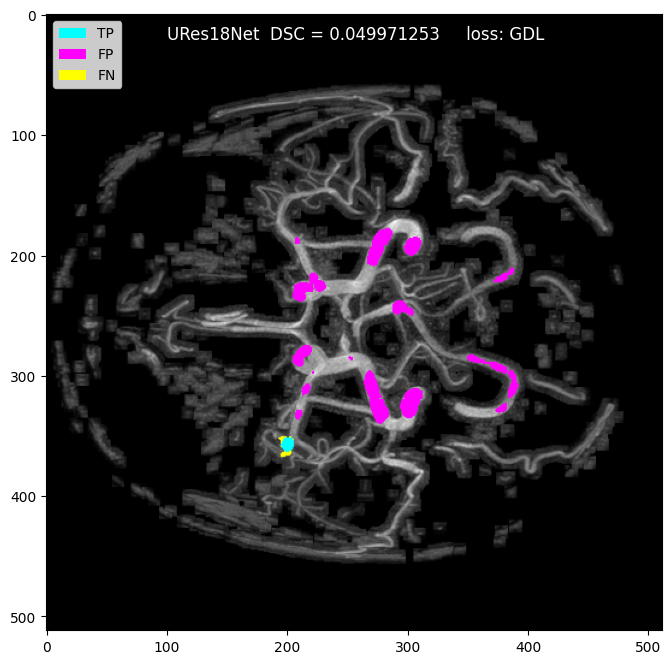

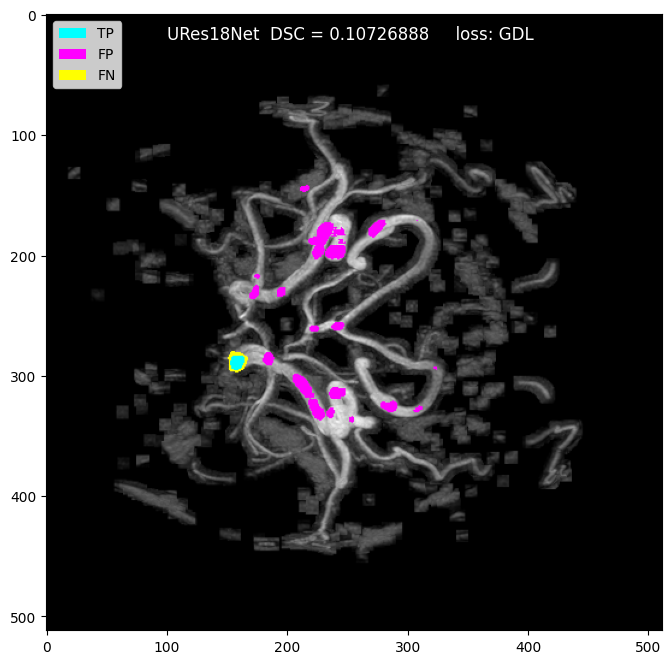

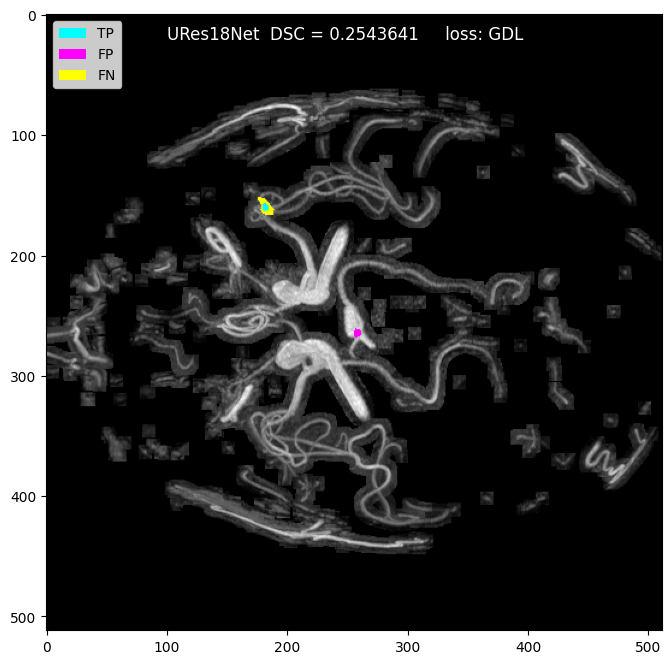

In [139]:
patch_size = 64
ypredict =[]

for caso in range(imgs_test.shape[0]):
  img_patches = patchify(imgs_test[caso,:,:,:],(patch_size,patch_size,patch_size), step=64)
  mask_patches = patchify(masks_test[caso,:,:],(patch_size,patch_size,patch_size), step=64)

  test_imgs_patches = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5])) #(128,64,64,64)
  test_masks_patches = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5])) #(128,64,64,64)

  test_imgs_patches = np.expand_dims(test_imgs_patches,-1) #(128,64,64,64,1)
  test_masks_patches = np.expand_dims(test_masks_patches,-1) #(128,64,64,64,1)


  prediction = att_res_unet_model.predict(test_imgs_patches, verbose=1, batch_size=2)
  prediction = prediction > 0.5

  ypred = np.reshape(prediction,(8,8,2,64,64,64))
  ypred = unpatchify(ypred,(512,512,128))

  imagen_rgb = np.stack((imgs_test[caso],)*3, axis=-1)
  imagen_rgb = np.max(imagen_rgb,2)

  #dsc = dice_coef(masks_test[caso,:,:,:],ypred)
  #print(dsc)

  ytrue = tf.convert_to_tensor(masks_test[caso,:,:,:],dtype='float32')
  ypredt = tf.convert_to_tensor(ypred,dtype='float32')

  dice = dice_coef(ytrue, ypredt).numpy()
  print(dice)

  ypredmip = np.max(ypred,2)
  masktestmip = np.max(masks_test[caso,:,:,:],2)

  for i in range(ypredmip.shape[0]):
          for j in range(ypredmip.shape[1]):
              if ypredmip[i,j] != 0:
                if ypredmip[i,j] == masktestmip[i,j]:
                  imagen_rgb[i,j,0] = 0
                  imagen_rgb[i,j,1] = 1
                  imagen_rgb[i,j,2] = 1
                else:
                  imagen_rgb[i,j,0] = 1
                  imagen_rgb[i,j,1] = 0
                  imagen_rgb[i,j,2] = 1
              else:
                if masktestmip[i,j] == 1:
                  imagen_rgb[i,j,0] = 1
                  imagen_rgb[i,j,1] = 1
                  imagen_rgb[i,j,2] = 0
  plt.figure(figsize=(8,8))
  plt.imshow(imagen_rgb)


  text = 'URes18Net  ' + 'DSC = ' + str(dice) + '     loss: GDL'
  pos_x = 100
  pos_y = 20
  plt.text(pos_x, pos_y, text, color='white', fontsize=12)

  legend_labels = ['TP', 'FP', 'FN']
  legend_colors = [[0,1,1] , [1,0,1] , [1,1,0]]

  # Create custom legend objects
  legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in legend_colors]

  # Add the legend to the image
  plt.legend(legend_patches, legend_labels, loc='upper left')

  #plt.savefig('/content/drive/MyDrive/DOCTORADO/3 Semestre/figuras resultados/' + 'URes50Net_' + str(caso) + '.png')

  ypredict.append(ypred)

ypredict = np.array(ypredict)

In [ ]:
y = masks_test

intersection_vol = np.logical_and(y, ypredict)
union_vol = np.logical_or(y, ypredict)

DSC_vol = round(2*np.sum(intersection_vol) / (np.sum(y) + np.sum(ypredict)),2) # 1 - (2TP / FP + 2TP + FN)

print('DSC = ',round(DSC_vol,2))

In [ ]:
#Nombre:  conv3d_14 , numero:  43 salida del encoder
input_layer = att_res_unet_model.input
encoder_output = att_res_unet_model.layers[43].output
classifier_input = layers.GlobalAveragePooling2D()(encoder_output)
clf1 = layers.Dense(64, activation='relu')(classifier_input)
clf2 = layers.Dense(128, activation='relu')(clf1)
clf_out = layers.Dense(1, activation='softmax')(clf2)
combined_model = Model(inputs= input_layer, outputs= [att_res_unet_model.output, clf_out])
combined_model.summary()

combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00005),
                       loss=[dice_loss, 'binary_crossentropy'],
                       loss_weights=[1.0, 0.5],  # Adjust the weights of the losses,
                       metrics={'output_1': [tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5), dice_coef], #metric for segmentation
                                'output_2':'accuracy'}) #metric for classification